# Named Entity Recognition (NER) on Groningen Meaning Bank (GMB) Corpus

# 1. Introduction

NER is the task of identifying useful information (entities) in text and categorising them into categories like names of persons, organizations, locations, time, quantities, monetary values and percentage. Entity can be a word or sequence of words in a sentence. Named-entity recognition is also known as entity identification, entity chunking and entity/information extraction. With the application of NER, a high level overview of any document can be obtained. 

## Business Problem

### Objective: 
Given a sentence as input, the objective here is to classify each word in the given sentence into pre defined classes of entities. 

### Data:
GMB dataset corpus is tagged, annotated and built specifically to train the model which can predict named entities such as name, location, etc.
Source-https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus?select=ner_dataset.csv

Essential info about entities:

-geo = Geographical Entity

-org = Organization

-per = Person

-gpe = Geopolitical Entity

-tim = Time indicator

-art = Artifact

-eve = Event

-nat = Natural Phenomenon

Above class of entities are labeled using the BIO scheme, where each entity label is prefixed with either B or I letter. B- denotes the beginning and I- inside of an entity. The words which are not of interest are labeled with 0.

### Challenge metric:
Accuracy is used as metric to train the model 

In [19]:
from google.colab import drive

drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [20]:
!pip install transformers

In [21]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import csv

import matplotlib.pyplot as plt
%matplotlib inline

from prettytable import PrettyTable

import os
import re
import json
import string
import numpy as np
import pandas as pd
import tensorflow as tf
import transformers
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import preprocessing
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, TFBertModel, BertConfig
import datetime

from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback


%tensorflow_version 2.x
import tensorflow as tf
import os
print(tf.__version__)

transformers.__version__

2.3.0


'3.0.2'

# 2. Data Pre-processing

In [22]:
#Read data path
data = "./gdrive/My Drive/ner_dataset.csv"
max_len = 384
configuration = BertConfig()

In [23]:
#Reference - https://keras.io/examples/nlp/text_extraction_with_bert/

# Get the sentences
def process_csv(data_path):
    df = pd.read_csv(data_path, encoding="latin-1")
    df.loc[:, "Sentence #"] = df["Sentence #"].fillna(method="ffill")
    enc_tag = preprocessing.LabelEncoder()
    df.loc[:, "Tag"] = enc_tag.fit_transform(df["Tag"])
    sentences = df.groupby("Sentence #")["Word"].apply(list).values
    tag = df.groupby("Sentence #")["Tag"].apply(list).values
    return sentences, tag, enc_tag

# Prepare the inputs for feeding into model
def create_inputs_targets(data):
    dataset_dict = {
        "input_ids": [],
        "token_type_ids": [],
        "attention_mask": [],
        "tags": []
    }
    sentences, tags, tag_encoder = process_csv(data)
    
    for sentence, tag in zip(sentences, tags):
        input_ids = []
        target_tags = []
        for idx, word in enumerate(sentence):
            ids = tokenizer.encode(word, add_special_tokens=False)
            input_ids.extend(ids.ids)
            num_tokens = len(ids)
            target_tags.extend([tag[idx]] * num_tokens)
                    
        
        # Pad truncate
        input_ids = input_ids[:max_len - 2]
        target_tags = target_tags[:max_len - 2]

        # Add [CLS] and [SEP]
        input_ids = [101] + input_ids + [102]
        target_tags = [16] + target_tags + [16]
        # token_type_ids does not matter as the task has only one sentence
        token_type_ids = [0] * len(input_ids)
        # Adding attention mask for non-padded input
        attention_mask = [1] * len(input_ids)
        
        # Making all the input enbedding same lenting by padding
        padding_len = max_len - len(input_ids)
        input_ids = input_ids + ([0] * padding_len)
        attention_mask = attention_mask + ([0] * padding_len)
        token_type_ids = token_type_ids + ([0] * padding_len)
        target_tags = target_tags + ([17] * padding_len)
        
        dataset_dict["input_ids"].append(input_ids)
        dataset_dict["token_type_ids"].append(token_type_ids)
        dataset_dict["attention_mask"].append(attention_mask)
        dataset_dict["tags"].append(target_tags)
        assert len(target_tags) == max_len, f'{len(input_ids)}, {len(target_tags)}'
                
    for key in dataset_dict:
        dataset_dict[key] = np.array(dataset_dict[key])

    # Creating array of input embeddings
    x = [
        dataset_dict["input_ids"],
        dataset_dict["token_type_ids"],
        dataset_dict["attention_mask"],
    ]
    y = dataset_dict["tags"]
    return x, y, tag_encoder


## 3. Tokenization

In [24]:
#Reference - https://keras.io/examples/nlp/text_extraction_with_bert/
# Save the slow pretrained tokenizer
slow_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
save_path = "bert_base_uncased/"
if not os.path.exists(save_path):
    os.makedirs(save_path)
slow_tokenizer.save_pretrained(save_path)

# Load the fast tokenizer from saved file
tokenizer = BertWordPieceTokenizer("bert_base_uncased/vocab.txt", lowercase=True)

## 4. Load Model and Finetune

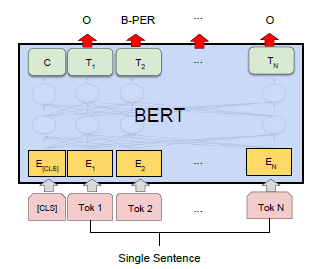

Above image illustrates fine tuning of BERT for NER task.
Source: https://arxiv.org/pdf/1810.04805.pdf

In [33]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction=tf.keras.losses.Reduction.SUM
)

# Ignoring loss that is calculated due to padded targets
def masked_ce_loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 17))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

def create_model(num_tags):
    # BERT Base model
    encoder = TFBertModel.from_pretrained("bert-base-uncased")

    # NER Model

    # Instantiate Keras tensors
    input_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
    token_type_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
    attention_mask = layers.Input(shape=(max_len,), dtype=tf.int32)
    # TFBertmodel
    embedding = encoder(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]
    # Add drop out layer
    embedding = layers.Dropout(0.5)(embedding)
    # Add softmax layer for classifying
    tag_logits = layers.Dense(num_tags+1, activation='softmax')(embedding)
    
    model = keras.Model(
        inputs=[input_ids, token_type_ids, attention_mask],
        outputs=[tag_logits],
    )
    optimizer = keras.optimizers.Adam(lr=3e-5)
    model.compile(optimizer=optimizer, loss=masked_ce_loss, metrics=['accuracy'])
    return model


In [34]:
#Reference - https://keras.io/examples/nlp/text_extraction_with_bert/

num_tags = pd.read_csv(data, encoding="latin-1")["Tag"].nunique()

use_tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    use_tpu = True
except:
    use_tpu = False

if use_tpu:
    # Create distribution strategy
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)

    # Create model
    with strategy.scope():
        model = create_model(num_tags)
else:
    model = create_model(num_tags)
    
model.summary()

INFO:tensorflow:Initializing the TPU system: grpc://10.73.77.90:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.73.77.90:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 384)]        0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 384)]        0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 384)]        0                                            
__________________________________________________________________________________________________
tf_bert_model_4 (TFBertModel)   ((None, 384, 768), ( 109482240   input_10[0][0]                   
                                                                 input_12[0][0]        

# 5. Train Model

In [35]:
x_train, y_train, tag_encoder = create_inputs_targets(data)

bs = 64 if use_tpu else 16

model.fit(
    x_train,
    y_train,
    epochs=1,
    verbose=1,
    batch_size=bs,
    validation_split=0.1
)



  2/675 [..............................] - ETA: 3:55:43 - loss: 437.3640 - accuracy: 0.4384WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0110s vs `on_train_batch_end` time: 0.2124s). Check your callbacks.


675/675 [==============================] - ETA: 0s - loss: nan - accuracy: 0.9922   WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0041s vs `on_test_batch_end` time: 0.0633s). Check your callbacks.


675/675 [==============================] - 243s 360ms/step - loss: nan - accuracy: 0.9922 - val_loss: 2.2910 - val_accuracy: 0.9970


# 6. Model Inference

In [36]:
# Prepate test inputs to feed into model
def create_test_input_from_text(texts):
    dataset_dict = {
        "input_ids": [],
        "token_type_ids": [],
        "attention_mask": []
    }
    for sentence in texts:
        input_ids = []
        for idx, word in enumerate(sentence.split()):
            ids = tokenizer.encode(word, add_special_tokens=False)
            input_ids.extend(ids.ids)
            num_tokens = len(ids)
                        
        # Pad and create attention masks.
        # Skip if truncation is needed
        input_ids = input_ids[:max_len - 2]

        input_ids = [101] + input_ids + [102]
        n_tokens = len(input_ids)
        token_type_ids = [0] * len(input_ids)
        attention_mask = [1] * len(input_ids)
        padding_len = max_len - len(input_ids)

        input_ids = input_ids + ([0] * padding_len)
        attention_mask = attention_mask + ([0] * padding_len)
        token_type_ids = token_type_ids + ([0] * padding_len)
        
        dataset_dict["input_ids"].append(input_ids)
        dataset_dict["token_type_ids"].append(token_type_ids)
        dataset_dict["attention_mask"].append(attention_mask)
        
    for key in dataset_dict:
        dataset_dict[key] = np.array(dataset_dict[key])

    x = [
        dataset_dict["input_ids"],
        dataset_dict["token_type_ids"],
        dataset_dict["attention_mask"],
    ]
    return dataset_dict, x, n_tokens

# test input sentence
test_inputs = ["India is 7th largest country by area"]
dataset, x_test, n_tokens = create_test_input_from_text(test_inputs)
x_test[0][0][:n_tokens]
pred_test = model.predict(x_test)
# ignore predictions of padding tokens
pred_tags = np.argmax(pred_test,2)[0][:n_tokens]  

# create dictionary of tag and its index
le_dict = dict(zip(tag_encoder.transform(tag_encoder.classes_), tag_encoder.classes_))
pred_tags = [le_dict.get(_, '[pad]') for _ in pred_tags]


In [37]:
for sentence in test_inputs:
  text = sentence.split(" ")

print(test_inputs)
pred_tags = pred_tags[1:-1]
print(pred_tags)


['India is 7th largest country by area']
['B-geo', 'O', 'O', 'O', 'O', 'O', 'O']


# 7. Conclusion

1. BERT model is used for NER task. 
2. bert-base-uncased model is downloaded and fine tuned for NER task.
3. Sparece Categorical crossentropy is used for calculating loss as this is a classification task. And, accuracy is used as metric.
4. Model is trained.The validation accuracy of model after evaluation is 99.7%. This is comparitively high than 99.2% accuracy of base model(Bi LSTM CRF model).
5. Model is tested on un-known data